In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

In [2]:
import time
import torch
from torch_geometric.loader import DataLoader
from tqdm import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

# from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

# from cutlass import *
# from rbfConv import *
from tqdm.notebook import tqdm
from BasisConvolution.detail.cutlass import cutlass
from torch.nn.parameter import Parameter

In [3]:
nx = 2
ny = 4
nz = 6
basis = 'linear'
periodic = False

fin = 6
fout = 8

ni = 16
nj = 8

support = 0.25
d = 1

In [4]:


positions_i = torch.rand((ni,d)).type(torch.float64)#fluidPositions[:128,:]
positions_j = torch.rand((nj,d)).type(torch.float64)#fluidPositions[:64,:]

fluidFeatures_i = torch.rand((positions_i.shape[0], fin)).type(torch.float64)
fluidFeatures_j = torch.rand((positions_j.shape[0], fin)).type(torch.float64)
fluidFeatures_i.requires_grad = False
fluidFeatures_j.requires_grad = False

fi, fj = radius(positions_j, positions_i, support, max_num_neighbors = 256, batch_x = None, batch_y = None)

fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
fluidEdgeLengths = (positions_j[fluidEdgeIndex[1]] - positions_i[fluidEdgeIndex[0]])/support

# weight = Parameter(torch.Tensor(nx,ny, fin, fout))
if d==1:
    weight = Parameter(torch.Tensor(nx, fin, fout))
elif d==2:
    weight = Parameter(torch.Tensor(nx,ny, fin, fout))
elif d==3:
    weight = Parameter(torch.Tensor(nx,ny,nz, fin, fout))
torch.nn.init.xavier_normal_(weight);

# with torch.no_grad():
#     weight[:,:,:,:] = 1

# debugPrint(fluidFeatures)
#         debugPrint(torch.min(fluidEdgeLengths))

convolution = cutlass.apply

# out = convolution(fluidEdgeIndex, fluidFeatures, fluidEdgeLengths, None, weight, 
#                                             fluidFeatures.shape[0], 0,
#                                         [nx, ny] , ['linear', 'linear'], [False, False], 
#                                         1,1)

# debugPrint(out)




# globalNumerical, globalAnalytical = None, None

# gradcheck(convOp, weight.type(torch.float64))

windowFn = lambda r: torch.ones_like(r)[:,0] * 2# torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)
windowFn = lambda r:torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)[:,0]
# windowFn = None
normalized = False

In [5]:
if d == 3:
    convOp = lambda features_i, features_j, x: convolution(fluidEdgeIndex, features_i.type(torch.float64), features_j, fluidEdgeLengths.type(torch.float64), windowFn(fluidEdgeLengths.type(torch.float64)) if windowFn is not None else None, x, 
                                            features_i.shape[0], 0,
                                        [nx, ny,nz] , [basis, basis, basis], [periodic, periodic, periodic], 
                                        1,1, normalized)
elif d == 2:
    convOp = lambda features_i, features_j, x: convolution(fluidEdgeIndex, features_i.type(torch.float64), features_j, fluidEdgeLengths.type(torch.float64), windowFn(fluidEdgeLengths.type(torch.float64)) if windowFn is not None else None, x, 
                                            fluidFeatures_i.shape[0], 0,
                                        [nx, ny] , [basis, basis], [periodic, periodic], 
                                        1,1, normalized)
else:
    convOp = lambda features_i, features_j, x: convolution(fluidEdgeIndex, features_i.type(torch.float64), features_j, fluidEdgeLengths.type(torch.float64), windowFn(fluidEdgeLengths.type(torch.float64)) if windowFn is not None else None, x,  
                                            fluidFeatures_i.shape[0], 0,
                                        [nx] , [basis], [periodic], 
                                        1,1, normalized)

In [6]:
from gradcheck import *

In [7]:
basis = 'fourier'

In [8]:
for d in [3, 2, 1]:
    print('Generating Data for d = %d' % d)
    positions_i = torch.rand((ni,d)).type(torch.float64)#fluidPositions[:128,:]
    positions_j = torch.rand((nj,d)).type(torch.float64)#fluidPositions[:64,:]

    fluidFeatures_i = torch.rand((positions_i.shape[0], fin)).type(torch.float64)
    fluidFeatures_j = torch.rand((positions_j.shape[0], fin)).type(torch.float64)
    fluidFeatures_i.requires_grad = False
    fluidFeatures_j.requires_grad = False

    fi, fj = radius(positions_j, positions_i, support, max_num_neighbors = 256, batch_x = None, batch_y = None)

    fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
    fluidEdgeLengths = (positions_j[fluidEdgeIndex[1]] - positions_i[fluidEdgeIndex[0]])/support
    if d==1:
        weight = Parameter(torch.Tensor(nx, fin, fout))
    elif d==2:
        weight = Parameter(torch.Tensor(nx,ny, fin, fout))
    elif d==3:
        weight = Parameter(torch.Tensor(nx,ny,nz, fin, fout))
    torch.nn.init.xavier_normal_(weight);
#     print('Done')
    
    for normalized in [True, False]:
        for windowFn in [None, lambda r:torch.clamp(torch.pow(1. - r, 4) * (1.0 + 4.0 * r), min = 0)[:,0]]:
            for basis in ['fourier', 'linear', 'dmcf']:
                if d == 3:
                    convOp = lambda features_i, features_j, x: convolution(fluidEdgeIndex, features_i.type(torch.float64), features_j, fluidEdgeLengths.type(torch.float64), windowFn(fluidEdgeLengths.type(torch.float64)) if windowFn is not None else None, x, 
                                                            features_i.shape[0], 0,
                                                        [nx, ny,nz] , [basis, basis, basis], [periodic, periodic, periodic], 
                                                        1,1, normalized)
                elif d == 2:
                    convOp = lambda features_i, features_j, x: convolution(fluidEdgeIndex, features_i.type(torch.float64), features_j, fluidEdgeLengths.type(torch.float64), windowFn(fluidEdgeLengths.type(torch.float64)) if windowFn is not None else None, x, 
                                                            fluidFeatures_i.shape[0], 0,
                                                        [nx, ny] , [basis, basis], [periodic, periodic], 
                                                        1,1, normalized)
                else:
                    convOp = lambda features_i, features_j, x: convolution(fluidEdgeIndex, features_i.type(torch.float64), features_j, fluidEdgeLengths.type(torch.float64), windowFn(fluidEdgeLengths.type(torch.float64)) if windowFn is not None else None, x,  
                                                            fluidFeatures_i.shape[0], 0,
                                                        [nx] , [basis], [periodic], 
                                                        1,1, normalized)
                print('Testing: d = %d, normalized = %5s, window = %5s, basis = %8s: ' % (d, 'true' if normalized else 'false', 'true' if windowFn is not None else 'false', basis), end = '')

                weight.requires_grad = True
                fluidFeatures_i.requires_grad = False
                fluidFeatures_j.requires_grad = False
                check = gradcheck(convOp, (fluidFeatures_i.type(torch.float64), fluidFeatures_j.type(torch.float64), weight.type(torch.float64)))
                print('Passed[XOO] ', end = '')

                weight.requires_grad = False
                fluidFeatures_i.requires_grad = False
                fluidFeatures_j.requires_grad = True
                check = gradcheck(convOp, (fluidFeatures_i.type(torch.float64), fluidFeatures_j.type(torch.float64), weight.type(torch.float64)))
                print('Passed[OOX] ', end = '')
                
                weight.requires_grad = True
                fluidFeatures_i.requires_grad = False
                fluidFeatures_j.requires_grad = True
                check = gradcheck(convOp, (fluidFeatures_i.type(torch.float64), fluidFeatures_j.type(torch.float64), weight.type(torch.float64)))
                print('Passed[XOX] ')
print('Done')

Generating Data for d = 3
Testing: d = 3, normalized =  true, window = false, basis =  fourier: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized =  true, window = false, basis =   linear: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized =  true, window = false, basis =     dmcf: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized =  true, window =  true, basis =  fourier: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized =  true, window =  true, basis =   linear: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized =  true, window =  true, basis =     dmcf: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized = false, window = false, basis =  fourier: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized = false, window = false, basis =   linear: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d = 3, normalized = false, window = false, basis =     dmcf: Passed[XOO] Passed[OOX] Passed[XOX] 
Testing: d 

In [9]:

from gradcheck import globalNumerical, globalAnalytical

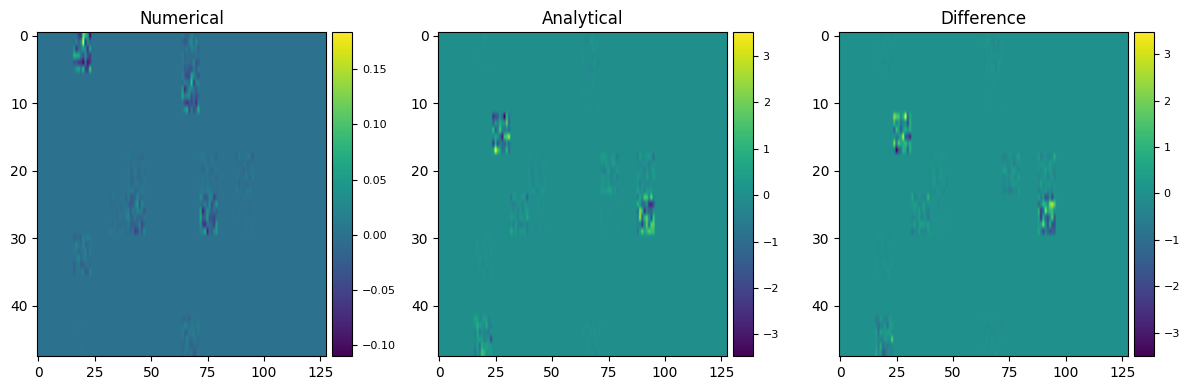

In [10]:
# This is only possible if there was an error
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('Numerical')
im = axis[0,0].imshow(globalNumerical)
ax1_divider = make_axes_locatable(axis[0,0])
axis[0,0].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

axis[0,1].set_title('Analytical')
im = axis[0,1].imshow(globalAnalytical)
ax1_divider = make_axes_locatable(axis[0,1])
axis[0,1].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

axis[0,2].set_title('Difference')
im = axis[0,2].imshow(globalNumerical - globalAnalytical)
ax1_divider = make_axes_locatable(axis[0,2])
axis[0,2].axis('auto')
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
numCbar = fig.colorbar(im, cax=cax1,orientation='vertical')
numCbar.ax.tick_params(labelsize=8) 

fig.tight_layout()
